### IMAGE CLASSIFICATION ON CIFAR-10 DATA SET

Importing Libraries

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D,Input,Dense,Dropout,Flatten,BatchNormalization,GlobalAveragePooling2D,Add
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,classification_report

Loading and Exploring the Data set

In [3]:
# Loading CIFAR-10 data set as train and test data
(x_train,y_train), (x_test,y_test) = cifar10.load_data()

# Printing the shape of train and test data
print("\033[1;36m Printing the shape of train and test data set : \033[0m")
print(f"x_train -> {x_train.shape}")
print(f"y_train -> {y_train.shape}")
print(f"x_test -> {x_test.shape}")
print(f"y_test -> {y_test.shape}")

 Printing the shape of train and test data set : 
x_train -> (50000, 32, 32, 3)
y_train -> (50000, 1)
x_test -> (10000, 32, 32, 3)
y_test -> (10000, 1)


Data Visualization

C:\Users\Sheni Nevil\AppData\Local\Temp\ipykernel_17516\2308242103.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label_index = int(y_train[index])


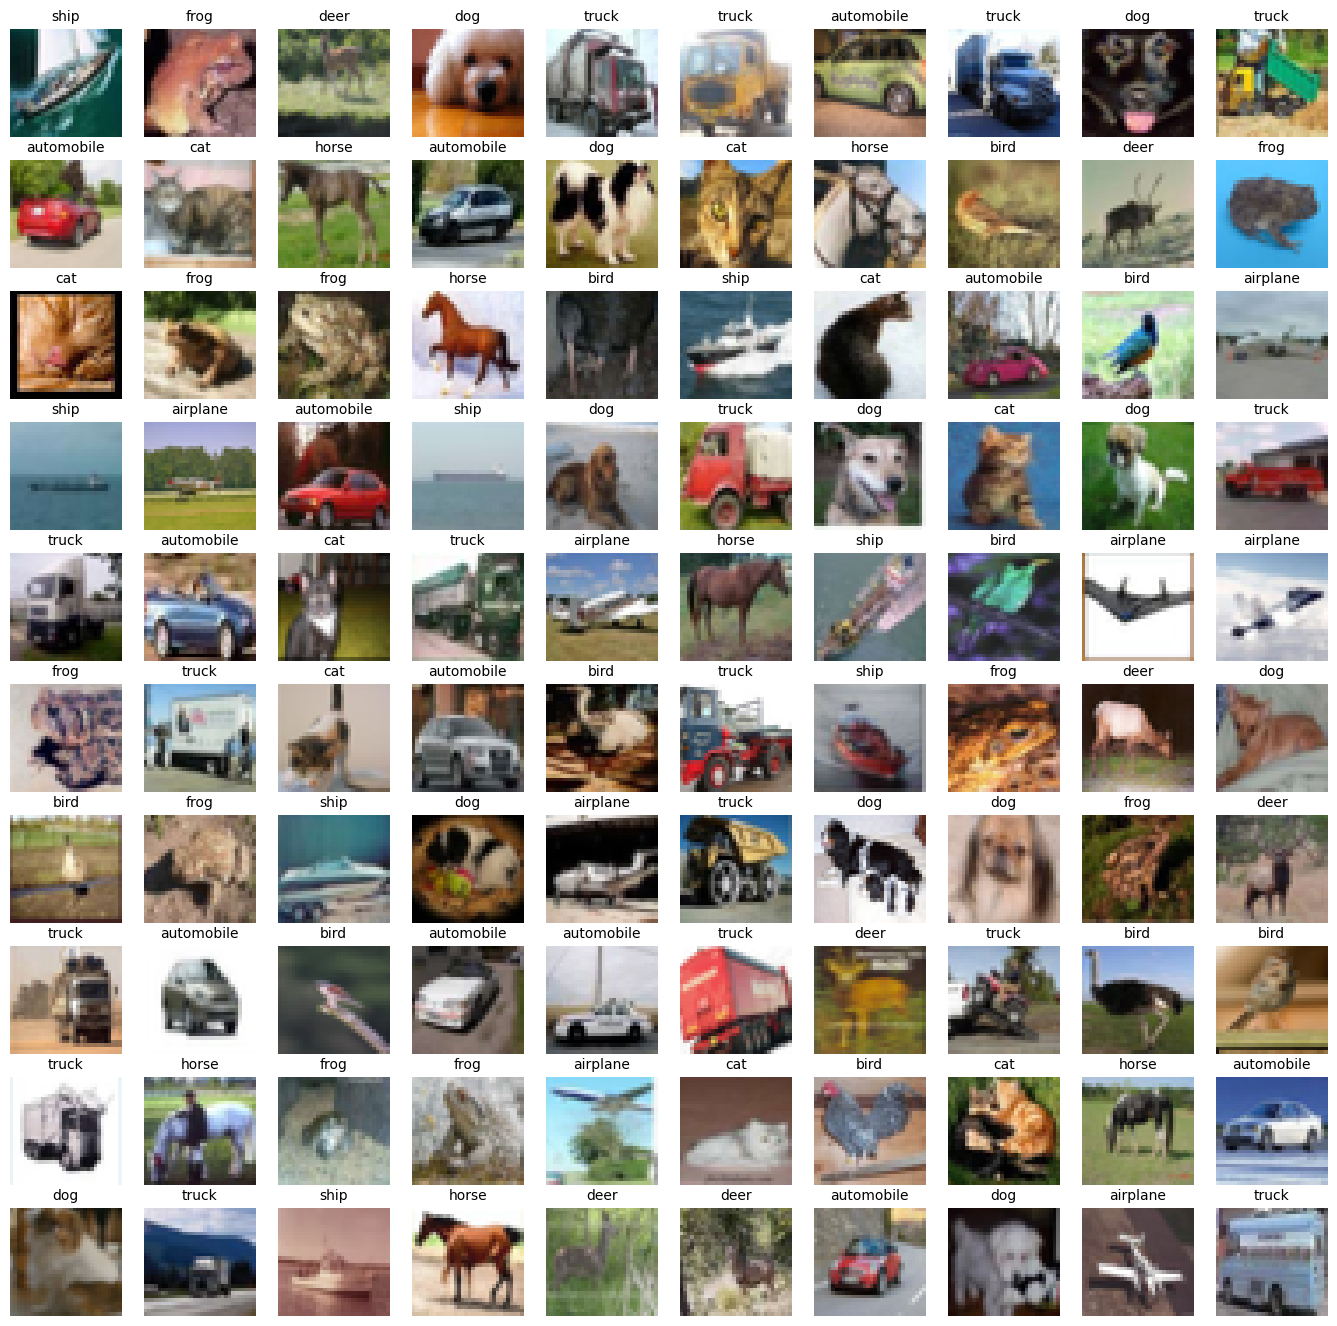

In [5]:
# Defining class labels of the CIFAR-10 data set
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Displaying a grid of 100 random images from training data
# Grid dimensions
W_grid,L_grid = 10,10
# subplot return the figure object and axes object(can be used to plot specific figures at various locations)
fig,axes = plt.subplots(L_grid,W_grid,figsize=(17,17))

# Flattening the 15x15 matrix to 225 array for easy indexing
axes = axes.ravel()

# Displaying random images in a grid format
for i in np.arange(0,W_grid*L_grid):
    # Selecting a random number from 0 to length of x_train
    index = np.random.randint(0,len(x_train))
    # Displaying image with the selected index    
    axes[i].imshow(x_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index],fontsize=10)
    axes[i].axis('off')
    
# Setting space between images
plt.subplots_adjust(hspace=0.01)

Data Preprocessing

In [7]:
# Scaling to normalize image pixel values to the range [0,1]
x_train = x_train/255.0
x_test = x_test/255.0

# Transforming labels to one-hot encoded format for categorical classification
y_cat_train = to_categorical(y_train,10)
y_cat_test = to_categorical(y_test,10)

Model Architecture (ResNet-18)

In [9]:
# Custom ResNet18 funtion block
def resnet_block(x,filters,kernel_size=3,stride=1,downsample=False):
    # Saving a copy of input tensor
    x_copy = x
    
    # First convolutional layer
    x = Conv2D(filters,kernel_size=kernel_size,strides=stride,padding='same')(x)
    # Normalizing the activations to improve training speed and stability
    x = BatchNormalization()(x)
    # Applying ReLU activation
    x = tf.keras.layers.ReLU()(x)
    
    # Second convolutional layer
    x = Conv2D(filters,kernel_size=kernel_size,strides=1,padding='same')(x)
    # Normalizing the activation
    x = BatchNormalization()(x)

    # If downsample is True, applying convolution to match dimensions
    if downsample:
        x_copy = Conv2D(filters,kernel_size=1,strides=stride,padding='same')(x_copy)
        x_copy = BatchNormalization()(x_copy)

    # Adding the input to the processed tensor
    x = Add()([x,x_copy])
    # Final ReLU activation after addition
    x = tf.keras.layers.ReLU()(x)
    return x

# ResNet18 architectural model
# Defining input tensor for the images(32x32 pixels with 3 color channels)
inputs = Input(shape=(32,32,3))
# Initial convolution and normalization layers with 64 filters 
x = Conv2D(64,kernel_size=3,strides=1,padding='same')(inputs)
x = BatchNormalization()(x)
x = tf.keras.layers.ReLU()(x)
# First set of ResNet block with 64 filters (no downsampling at all)
x = resnet_block(x,64)
x = resnet_block(x,64)

# Second set of ResNet block with 128 filters (downsampling in first block)
x = resnet_block(x,128, stride=2,downsample=True)
x = resnet_block(x,128)

# Third set of ResNet blocks with 256 filters (downsampling in first block)
x = resnet_block(x,256,stride=2,downsample=True)
x = resnet_block(x,256)

# Fourth set of ResNet blocks with 512 filters (downsampling in first block)
x = resnet_block(x,512,stride=2,downsample=True)
x = resnet_block(x,512)

# Global average pooling to reduce each feature map to a single value
x = GlobalAveragePooling2D()(x)
# Output layer for 10 classes, using softmax activation
outputs = Dense(10,activation='softmax')(x)

# Defining the model by specifying inputs and outputs
model = Model(inputs=inputs,outputs=outputs)

# Compiling the model
m = ['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=m)

Data Augmentation

In [11]:
# Setting up data augmentation
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True)
train_generator = data_generator.flow(x_train,y_cat_train,batch_size)
steps_per_epoch = x_train.shape[0]//batch_size

# Training the model
r = model.fit(train_generator,epochs=10,steps_per_epoch=steps_per_epoch,validation_data=(x_test,y_cat_test))

Epoch 1/10


C:\Users\Sheni Nevil\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 1958s 1s/step - accuracy: 0.4100 - loss: 1.6723 - precision: 0.5603 - recall: 0.2264 - val_accuracy: 0.6081 - val_loss: 1.1775 - val_precision: 0.7003 - val_recall: 0.5170
Epoch 2/10
   1/1562 ━━━━━━━━━━━━━━━━━━━━ 38:05 1s/step - accuracy: 0.6875 - loss: 0.7777 - precision: 0.7600 - recall: 0.5938

C:\Users\Sheni Nevil\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


1562/1562 ━━━━━━━━━━━━━━━━━━━━ 95s 60ms/step - accuracy: 0.6875 - loss: 0.7777 - precision: 0.7600 - recall: 0.5938 - val_accuracy: 0.6098 - val_loss: 1.1643 - val_precision: 0.7050 - val_recall: 0.5206
Epoch 3/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 2212s 1s/step - accuracy: 0.6807 - loss: 0.9124 - precision: 0.7841 - recall: 0.5836 - val_accuracy: 0.6047 - val_loss: 1.2684 - val_precision: 0.6614 - val_recall: 0.5495
Epoch 4/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 122s 78ms/step - accuracy: 0.5312 - loss: 1.1209 - precision: 0.6800 - recall: 0.5312 - val_accuracy: 0.6054 - val_loss: 1.2546 - val_precision: 0.6624 - val_recall: 0.5533
Epoch 5/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 2850s 2s/step - accuracy: 0.7468 - loss: 0.7264 - precision: 0.8219 - recall: 0.6777 - val_accuracy: 0.7145 - val_loss: 0.8880 - val_precision: 0.7897 - val_recall: 0.6474
Epoch 6/10
1562/1562 ━━━━━━━━━━━━━━━━━━━━ 186s 118ms/step - accuracy: 0.8125 - loss: 0.4925 - precision: 0.8929 - recall: 0.7812 - val_accuracy: 0.7072 - 

Plotting Training Metrics

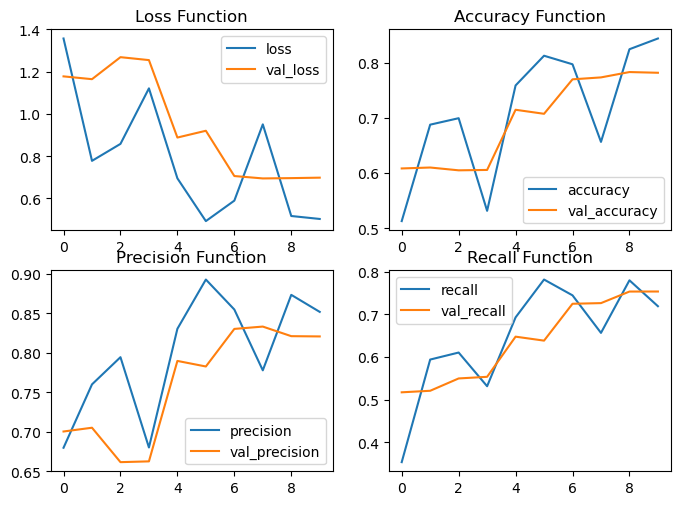

In [15]:
# Plotting training history for loss, accuracy, precision, and recall
plt.figure(figsize=(8,12))

plt.subplot(4,2,1)
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.title('Loss Function')
plt.legend()

plt.subplot(4,2,2)
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.title('Accuracy Function')
plt.legend()

plt.subplot(4,2,3)
plt.plot(r.history['precision'],label='precision')
plt.plot(r.history['val_precision'],label='val_precision')
plt.title('Precision Function')
plt.legend()

plt.subplot(4,2,4)
plt.plot(r.history['recall'],label='recall')
plt.plot(r.history['val_recall'],label='val_recall')
plt.title('Recall Function')
plt.legend()

Prediction and Evaluation

313/313 ━━━━━━━━━━━━━━━━━━━━ 87s 274ms/step
 PLOT OF CONFUSION MATRIX : 


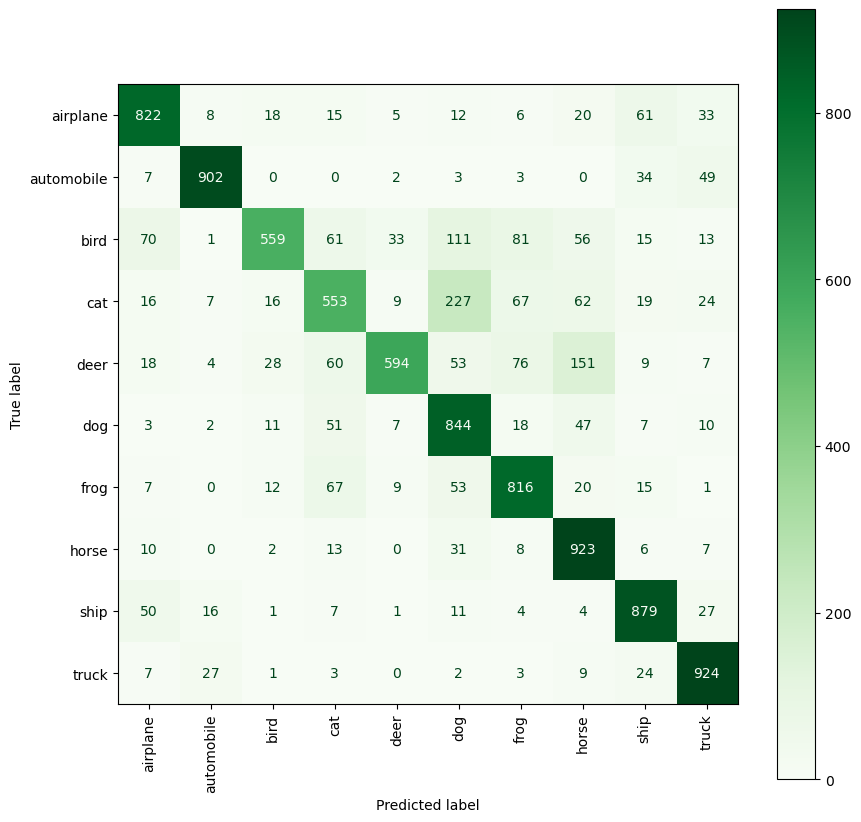

 Classification Report : 

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1000
           1       0.93      0.90      0.92      1000
           2       0.86      0.56      0.68      1000
           3       0.67      0.55      0.60      1000
           4       0.90      0.59      0.72      1000
           5       0.63      0.84      0.72      1000
           6       0.75      0.82      0.78      1000
           7       0.71      0.92      0.81      1000
           8       0.82      0.88      0.85      1000
           9       0.84      0.92      0.88      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



In [17]:
# Predicting labels for test data
y_pred = model.predict(x_test)
# Getting class with highest predicted probability
y_pred = np.argmax(y_pred,axis=1)

# Calculating confusion matrix
cm = confusion_matrix(y_test,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
disp = disp.plot(xticks_rotation='vertical',ax=ax,cmap='Greens')
print("\033[1;36m PLOT OF CONFUSION MATRIX : \033[0m")
plt.show()

# Printing classification report
print("\033[1;36m Classification Report : \033[0m\n")
print(classification_report(y_test, y_pred))